In [30]:
# This is a script to retrieve time series data from the BLS API.
# This example focuses on a single time series, the Labor Force Participation Rate.
# Tutorial and code from https://www.bd-econ.com/blsapi.html

# BLS API v1 url
base_url = 'https://api.bls.gov/publicAPI/v1/timeseries/data/'

In [31]:
# BLS series id for the civilian labor force participation rate
series = {'id': 'LNS11300000',
          'name': 'Labor Force Participation Rate'}

In [32]:
data_url = '{}{}'.format(base_url, series['id'])
print(data_url)

https://api.bls.gov/publicAPI/v1/timeseries/data/LNS11300000


In [33]:
# Use the requests package to get data from the data_url. By specifying that the data are in json format, 
#  we convert the output to nested python dictionaries and lists. 
# The status of the request is printed and the top-level dictionary is stored as variable r
import requests

r = requests.get(data_url).json()
print('Status: ' + r['status'])

Status: REQUEST_SUCCEEDED


In [34]:
# The dictionary r contains several keys:
print(r.keys())
[u'status', u'message', u'Results', u'responseTime']

dict_keys(['status', 'responseTime', 'message', 'Results'])


['status', 'message', 'Results', 'responseTime']

In [35]:
# The Results key contains the series list, of which the first item (python lists start with item 0) 
#  contains our data: r['Results']['series'][0]['data']. The data are a list of dictionaries with the first item 
#  ([0]) being the most recent set of values, footnotes, and date information, printed below.
r = r['Results']['series'][0]['data']
print(r[0])

{'year': '2021', 'period': 'M07', 'periodName': 'July', 'latest': 'true', 'value': '61.7', 'footnotes': [{}]}


In [26]:
# Read into Pandas
# We create a dataframe by telling pandas the index, data, and name. 
# Since the data in this case are a monthly time series, we can identify that the index for the series 
# contains dates. Below a list of dates, which will be the index of the dataframe, is constructed from 
# the values obtained using the period and year dictionary keys seen above. 
# The first column of the pandas dataframe is the series values, named with the series id. 
# Just in case they contain relevant information, the BLS footnotes are included as a second column.
import pandas as pd

dates = ['{} {}'.format(i['period'], i['year']) for i in r]
index = pd.to_datetime(dates)
data = {series['id']: [float(i['value']) for i in r],
        'footnotes': [i['footnotes'][0] for i in r]}

df = pd.DataFrame(index=index, data=data).iloc[::-1]

df.tail(3)

,LNS11300000,footnotes
2021-01-01 00:00:05,61.6,{}
2021-01-01 00:00:06,61.6,{}
2021-01-01 00:00:07,61.7,{}


<AxesSubplot:title={'center':'Labor Force Participation Rate'}>

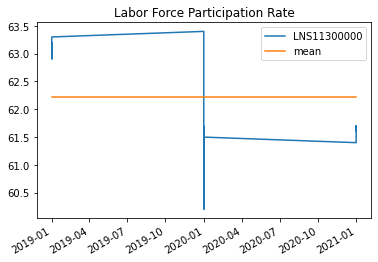

In [36]:
# Calculate the average value for the period and plot both the monthly values and average value to look for trends.
import matplotlib

%matplotlib inline

df['mean'] = df[series['id']].mean()
df[[series['id'], 'mean']].plot(title=series['name'])

In [37]:
# Importing config.py to access its variables
# You will need to register with BLS, receive an API key, create a config.py file in the notebook's directory
#  and then put the key in the file bls_key = 'key'

import config

# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
key = '?registrationkey={}'.format(config.bls_key)

# Series stored as a dictionary
series_dict = {
    'LNS14000003': 'White',
    'LNS14000006': 'Black',
    'LNS14000009': 'Hispanic'}

# Start year and end year
dates = ('2008', '2017')

In [38]:
import json

# Specify json as content type to return
headers = {'Content-type': 'application/json'}

# Submit the list of series as data
data = json.dumps({
    "seriesid": list(series_dict.keys()),
    "startyear": dates[0],
    "endyear": dates[1]})

# Post request for the data
p = requests.post(
    '{}{}'.format(url, key),
    headers=headers,
    data=data).json()['Results']['series']

In [41]:
# Since the API returns data in a uniform way,   
#  a for loop can be used to apply formatting or other changes to all series in the returned json data. 
#  In the example below, all three series are converted to pandas series with a datetime index 
#  and the values converted to floats.

# Date index from first series
date_list = [f"{i['year']}-{i['period'][1:]}-01" for i in p[0]['data']]

# Empty dataframe to fill with values
df = pd.DataFrame()

# Build a pandas series from the API results, p
for s in p:
    df[series_dict[s['seriesID']]] = pd.Series(
        index = pd.to_datetime(date_list),
        data = [i['value'] for i in s['data']]
        ).astype(float).iloc[::-1]

# Show last 5 results
df.tail()

,White,Black,Hispanic
2017-08-01,3.9,7.5,5.1
2017-09-01,3.7,7.2,5.1
2017-10-01,3.6,7.6,5.0
2017-11-01,3.7,7.5,4.9
2017-12-01,3.7,6.9,5.0


<AxesSubplot:title={'center':'Unemployment Rates by Race or Origin'}>

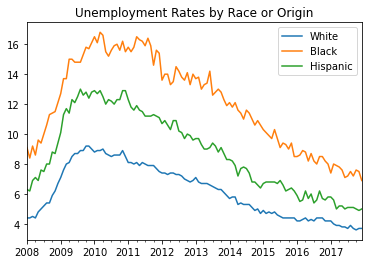

In [42]:
# Simple line plot of the data
df.plot(title='Unemployment Rates by Race or Origin')